In [1]:
%matplotlib inline
import cv2
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab
import numpy as np
import quat_math as qm
from generic_pose.utils import to_np, to_var

import warnings; warnings.simplefilter('ignore')
pylab.rcParams['figure.figsize'] = 20, 12

In [2]:
def imshow(img, axis = False):
    if not axis:
        plt.axis('off')
    plt.imshow(img)
    plt.show()

In [3]:
def imshowCV(img, axis = False):
    if not axis:
        plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [4]:
def torch2Img(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    disp_img = to_np(img)
    if len(disp_img.shape) == 4:
        disp_img = disp_img[0]
    disp_img = disp_img.transpose((1,2,0))
    disp_img = disp_img * std + mean
    return disp_img

In [5]:
#from generic_pose.utils.image_preprocessing import unprocessImages
def imshowTorch(img, axis = False):
    if not axis:
        plt.axis('off')
    disp_img = torch2Img(img)
    plt.imshow(disp_img.astype(np.uint8))
    #plt.imshow(unprocessImages(img)[0])
    plt.show()

In [6]:
eps = 1e-6
def tensorAngularAllDiffs(label_qs, est_qs):
    return 2 * torch.acos(torch.abs(torch.transpose(torch.mm(est_qs, 
        torch.transpose(label_qs,0,1)),0,1)).clamp(max=1-eps))
def tensorAngularDiff(q1, q2):
    return 2 * torch.acos(torch.abs((q1*q2).sum(1)).clamp(max=1-eps))

In [7]:
dataset_root = './datasets/ycb/YCB_Video_Dataset'
model_checkpoint = 'trained_checkpoints/ycb/pose_model_26_0.012863246640872631.pth'
refine_model_checkpoint = 'trained_checkpoints/ycb/pose_refine_model_69_0.009449292959118935.pth'

In [8]:
import os
import copy
import random
import numpy as np
from PIL import Image
import scipy.io as scio
import scipy.misc
import numpy.ma as ma
import math
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from torch.autograd import Variable
from datasets.ycb.dataset import PoseDataset
from lib.network import PoseNet, PoseRefineNet
from lib.transformations import euler_matrix, quaternion_matrix, quaternion_from_matrix

In [10]:
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
border_list = [-1, 40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680]
xmap = np.array([[j for i in range(640)] for j in range(480)])
ymap = np.array([[i for i in range(640)] for j in range(480)])
cam_cx = 312.9869
cam_cy = 241.3109
cam_fx = 1066.778
cam_fy = 1067.487
cam_scale = 10000.0
num_obj = 21
img_width = 480
img_length = 640
num_points = 1000
num_points_mesh = 500
iteration = 2
bs = 1
dataset_config_dir = 'datasets/ycb/dataset_config'
ycb_toolbox_dir = 'YCB_Video_toolbox'
result_wo_refine_dir = 'experiments/eval_result/ycb/Densefusion_wo_refine_result'
result_refine_dir = 'experiments/eval_result/ycb/Densefusion_iterative_result'

with open('datasets/ycb/YCB_Video_Dataset/image_sets/classes.txt') as f:
    classes = f.read().split()
classes.insert(0, 'background')

In [11]:
def get_bbox(posecnn_rois, idx = 0):
    rmin = int(posecnn_rois[idx][3]) + 1
    rmax = int(posecnn_rois[idx][5]) - 1
    cmin = int(posecnn_rois[idx][2]) + 1
    cmax = int(posecnn_rois[idx][4]) - 1
    r_b = rmax - rmin
    for tt in range(len(border_list)):
        if r_b > border_list[tt] and r_b < border_list[tt + 1]:
            r_b = border_list[tt + 1]
            break
    c_b = cmax - cmin
    for tt in range(len(border_list)):
        if c_b > border_list[tt] and c_b < border_list[tt + 1]:
            c_b = border_list[tt + 1]
            break
    center = [int((rmin + rmax) / 2), int((cmin + cmax) / 2)]
    rmin = center[0] - int(r_b / 2)
    rmax = center[0] + int(r_b / 2)
    cmin = center[1] - int(c_b / 2)
    cmax = center[1] + int(c_b / 2)
    if rmin < 0:
        delt = -rmin
        rmin = 0
        rmax += delt
    if cmin < 0:
        delt = -cmin
        cmin = 0
        cmax += delt
    if rmax > img_width:
        delt = rmax - img_width
        rmax = img_width
        rmin -= delt
    if cmax > img_length:
        delt = cmax - img_length
        cmax = img_length
        cmin -= delt
    return rmin, rmax, cmin, cmax

In [14]:
estimator = PoseNet(num_points = num_points, num_obj = num_obj)
estimator.cuda()
estimator.load_state_dict(torch.load(model_checkpoint))
estimator.eval()

refiner = PoseRefineNet(num_points = num_points, num_obj = num_obj)
refiner.cuda()
refiner.load_state_dict(torch.load(refine_model_checkpoint))
refiner.eval()

PoseRefineNet(
  (feat): PoseRefineNetFeat(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (e_conv1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (e_conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv5): Conv1d(384, 512, kernel_size=(1,), stride=(1,))
    (conv6): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
    (ap1): AvgPool1d(kernel_size=(1000,), stride=(1000,), padding=(0,))
  )
  (conv1_r): Linear(in_features=1024, out_features=512, bias=True)
  (conv1_t): Linear(in_features=1024, out_features=512, bias=True)
  (conv2_r): Linear(in_features=512, out_features=128, bias=True)
  (conv2_t): Linear(in_features=512, out_features=128, bias=True)
  (conv3_r): Linear(in_features=128, out_features=84, bias=True)
  (conv3_t): Linear(in_features=128, out_features=63, bias=True)
)

In [15]:
testlist = []
input_file = open('{0}/test_data_list.txt'.format(dataset_config_dir))
while 1:
    input_line = input_file.readline()
    if not input_line:
        break
    if input_line[-1:] == '\n':
        input_line = input_line[:-1]
    testlist.append(input_line)
input_file.close()
print(len(testlist))

2949


In [16]:
class_file = open('{0}/classes.txt'.format(dataset_config_dir))
class_id = 1
cld = {}
while 1:
    class_input = class_file.readline()
    if not class_input:
        break
    class_input = class_input[:-1]

    input_file = open('{0}/models/{1}/points.xyz'.format(dataset_root, class_input))
    cld[class_id] = []
    while 1:
        input_line = input_file.readline()
        if not input_line:
            break
        input_line = input_line[:-1]
        input_line = input_line.split(' ')
        cld[class_id].append([float(input_line[0]), float(input_line[1]), float(input_line[2])])
    input_file.close()
    cld[class_id] = np.array(cld[class_id])
    class_id += 1


In [17]:
def estimatePose(img, depth, posecnn_meta, idx = 0):
    label = np.array(posecnn_meta['labels'])
    posecnn_rois = np.array(posecnn_meta['rois'])
    lst = posecnn_rois[:, 1:2].flatten()

    itemid = lst[idx]

    rmin, rmax, cmin, cmax = get_bbox(posecnn_rois, idx)

    mask_depth = ma.getmaskarray(ma.masked_not_equal(depth, 0))
    mask_label = ma.getmaskarray(ma.masked_equal(label, itemid))
    mask = mask_label * mask_depth

    choose = mask[rmin:rmax, cmin:cmax].flatten().nonzero()[0]
    if len(choose) > num_points:
        c_mask = np.zeros(len(choose), dtype=int)
        c_mask[:num_points] = 1
        np.random.shuffle(c_mask)
        choose = choose[c_mask.nonzero()]
    elif len(choose) > 0:
        choose = np.pad(choose, (0, num_points - len(choose)), 'wrap')
    else:
        return None

    depth_masked = depth[rmin:rmax, cmin:cmax].flatten()[choose][:, np.newaxis].astype(np.float32)
    xmap_masked = xmap[rmin:rmax, cmin:cmax].flatten()[choose][:, np.newaxis].astype(np.float32)
    ymap_masked = ymap[rmin:rmax, cmin:cmax].flatten()[choose][:, np.newaxis].astype(np.float32)
    choose = np.array([choose])

    pt2 = depth_masked / cam_scale
    pt0 = (ymap_masked - cam_cx) * pt2 / cam_fx
    pt1 = (xmap_masked - cam_cy) * pt2 / cam_fy
    cloud = np.concatenate((pt0, pt1, pt2), axis=1)

    img_masked = np.array(img)[:, :, :3]
    img_masked = np.transpose(img_masked, (2, 0, 1))
    img_masked = img_masked[:, rmin:rmax, cmin:cmax]

    cloud = torch.from_numpy(cloud.astype(np.float32))
    choose = torch.LongTensor(choose.astype(np.int32))
    img_masked = norm(torch.from_numpy(img_masked.astype(np.float32)))
    index = torch.LongTensor([itemid - 1])

    cloud = Variable(cloud).cuda()
    choose = Variable(choose).cuda()
    img_masked = Variable(img_masked).cuda()
    index = Variable(index).cuda()

    cloud = cloud.view(1, num_points, 3)
    img_masked = img_masked.view(1, 3, img_masked.size()[1], img_masked.size()[2])

    pred_r, pred_t, pred_c, emb = estimator(img_masked, cloud, choose, index)
    pred_r = pred_r / torch.norm(pred_r, dim=2).view(1, num_points, 1)
    pred_c = pred_c.view(bs, num_points)
    how_max, which_max = torch.max(pred_c, 1)
    pred_t = pred_t.view(bs * num_points, 1, 3)
    points = cloud.view(bs * num_points, 1, 3)
    pred_r_pre = pred_r
    pred_t_pre = pred_t
    
    my_r = pred_r[0][which_max[0]].view(-1).cpu().data.numpy()
    my_t = (points + pred_t)[which_max[0]].view(-1).cpu().data.numpy()

    for ite in range(0, iteration):
        T = Variable(torch.from_numpy(my_t.astype(np.float32))).cuda().view(1, 3).repeat(num_points, 1).contiguous().view(1, num_points, 3)
        my_mat = quaternion_matrix(my_r)
        R = Variable(torch.from_numpy(my_mat[:3, :3].astype(np.float32))).cuda().view(1, 3, 3)
        my_mat[0:3, 3] = my_t

        new_cloud = torch.bmm((cloud - T), R).contiguous()
        pred_r, pred_t = refiner(new_cloud, emb, index)
        pred_r = pred_r.view(1, 1, -1)
        pred_r = pred_r / (torch.norm(pred_r, dim=2).view(1, 1, 1))
        my_r_2 = pred_r.view(-1).cpu().data.numpy()
        my_t_2 = pred_t.view(-1).cpu().data.numpy()
        my_mat_2 = quaternion_matrix(my_r_2)

        my_mat_2[0:3, 3] = my_t_2

        my_mat_final = np.dot(my_mat, my_mat_2)
        my_r_final = copy.deepcopy(my_mat_final)
        my_r_final[0:3, 3] = 0
        my_r_final = quaternion_from_matrix(my_r_final, True)
        my_t_final = np.array([my_mat_final[0][3], my_mat_final[1][3], my_mat_final[2][3]])

        my_pred = np.append(my_r_final, my_t_final)
        my_r = my_r_final
        my_t = my_t_final

    coords = np.unravel_index(to_np(choose), img_masked.shape[2:])

    res = {'r':pred_r_pre.detach(), 
           't':pred_t_pre.detach(), 
           'c':pred_c.detach(), 
           'r_refine':my_r_final, 
           't_refine':my_t_final, 
           'emb':emb.detach(),
           'cropped':img_masked.detach(), 
           'cloud':cloud.detach(), 
           'corr':choose.detach(),
           'coords':coords,
           'bbox':(rmin, rmax, cmin, cmax)}
    return res

0.5125489 (133, 121)


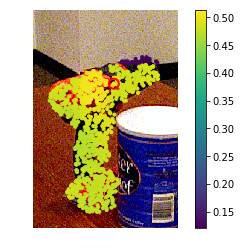

In [18]:
img_idx = 2000
obj_idx = 2

img = Image.open('{0}/{1}-color.png'.format(dataset_root, testlist[img_idx]))

#imshow(img)

depth = np.array(Image.open('{0}/{1}-depth.png'.format(dataset_root, testlist[img_idx])))
pose_meta = scio.loadmat('{0}/{1}-meta.mat'.format(dataset_root, testlist[img_idx]))
posecnn_meta = scio.loadmat('{0}/results_PoseCNN_RSS2018/{1}.mat'.format(ycb_toolbox_dir, '%06d' % img_idx))

res = estimatePose(img, depth, posecnn_meta, idx=obj_idx)
disp_img = torch2Img(res['cropped'])
coords = res['coords']
c_vals = to_np(res['c'])
max_idx = np.argmax(c_vals)
print(np.max(c_vals), (coords[1][0,max_idx], coords[0][0,max_idx]))

plt.axis('off')
plt.imshow(disp_img.astype(np.uint8))
plt.scatter(coords[1], coords[0], 10, c_vals)
plt.colorbar()

plt.scatter(coords[1][0,max_idx], coords[0][0,max_idx], 100,
            facecolors='none', edgecolors='r', lw=2, marker='o')

plt.show()


In [19]:
pose_meta = scio.loadmat('{0}/{1}-meta.mat'.format(dataset_root, testlist[img_idx]))
posecnn_idx = posecnn_meta['rois'][obj_idx, 1]
pose_idx = np.where(pose_meta['cls_indexes'].flatten()==posecnn_idx)[0][0]
trans_mat = pose_meta['poses'][:,:, pose_idx]
R_gt = np.eye(4)
R_gt[:3,:3] = trans_mat[:3,:3]
#ycb_mat = euler_matrix(-np.pi/2,0,0)
#R_gt = R_gt.dot(ycb_mat)
q_gt = qm.quaternion_from_matrix(R_gt)

t_gt = trans_mat[:3,3]
q_est = to_np(res['r'][0,max_idx])[[1,2,3,0]]
t_est = to_np(res['cloud'][0,max_idx] + res['t'][max_idx,0])
q_ref = res['r_refine'][[1,2,3,0]]
t_ref = res['t_refine']
print('GT  Quat: ', q_gt)
print('Est Quat: ', q_est)
print('Ref Quat: ', q_ref)
print('Gt  Trans:', t_gt)
print('Est Trans:', t_est)
print('Ref Trans:', t_ref)


GT  Quat:  [-0.41406882 -0.154376    0.89442464  0.06870013]
Est Quat:  [-0.43305218 -0.16273157  0.8792508   0.11358753]
Ref Quat:  [-0.46218834 -0.16435508  0.86857027  0.07039206]
Gt  Trans: [-0.12106987 -0.01967303  0.84392517]
Est Trans: [-0.12490913 -0.02125016  0.846948  ]
Ref Trans: [-0.12526389 -0.02133691  0.83872761]


In [20]:
t_err = to_np(torch.norm(res['cloud'][0,:] + res['t'][:,0] \
                         - to_var(torch.tensor(t_gt).float()), dim=1))
q_err = 180.0/np.pi*to_np(tensorAngularDiff(res['r'][0,:,[1,2,3,0]], 
                                to_var(torch.tensor(q_gt).float())))

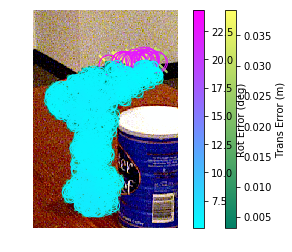

In [21]:
fig, ax = plt.subplots()
ax.axis('off')
plt.imshow(disp_img.astype(np.uint8))

cmap_t = mpl.cm.get_cmap('summer')
normalize_t = mpl.colors.Normalize(vmin=min(t_err), vmax=max(t_err))
colors_t = [cmap_t(normalize_t(value)) for value in t_err]
cmap_q = mpl.cm.get_cmap('cool')
normalize_q = mpl.colors.Normalize(vmin=min(q_err), vmax=max(q_err))
colors_q = [cmap_q(normalize_q(value)) for value in q_err]

h_t = ax.scatter(coords[1], coords[0], s = 50/c_vals,
                  color=colors_t, 
                  lw=2, marker='x')
h_q = ax.scatter(coords[1], coords[0], s = 50/c_vals, 
                  facecolors='none', edgecolors=colors_q, 
                  lw=1, marker='o')
#plt.colorbar()
#cb_t = plt.colorbar(h_t,shrink=0.25)
#cb_q = plt.colorbar(h_q,shrink=0.25)
cax_t, _ = mpl.colorbar.make_axes(ax, fraction=0.05)
cb_t = mpl.colorbar.ColorbarBase(cax_t, cmap=cmap_t, norm=normalize_t)
cb_t.set_label('Trans Error (m)')

cax_q, _ = mpl.colorbar.make_axes(ax, fraction=0.05)
cb_q = mpl.colorbar.ColorbarBase(cax_q, cmap=cmap_q, norm=normalize_q)
cb_q.set_label('Rot Error (deg)')
plt.show()

In [22]:
def poseError(res, gt_mat):
    R_gt = np.eye(4)
    R_gt[:3,:3] = gt_mat[:3,:3]
    #ycb_mat = euler_matrix(-np.pi/2,0,0)
    #R_gt = R_gt.dot(ycb_mat)
    q_gt = qm.quaternion_from_matrix(R_gt)
    max_idx = torch.argmax(res['c'])
    t_gt = trans_mat[:3,3]
    q_est = res['r'][0,max_idx][[1,2,3,0]]
    t_est = res['cloud'][0,max_idx] + res['t'][max_idx,0]
    q_ref = res['r_refine'][[1,2,3,0]]
    t_ref = res['t_refine']
    
    t_err_est = to_np(torch.norm(t_est - to_var(torch.tensor(t_gt).float())))
    q_err_est = 180.0/np.pi*to_np(tensorAngularDiff(q_est.unsqueeze(0), to_var(torch.tensor(q_gt).float())))
    
    t_err_ref = np.linalg.norm(t_ref - t_gt)
    q_err_ref = 180.0/np.pi*qm.quatAngularDiff(q_ref, q_gt)
    
    t_err_all = to_np(torch.norm(res['cloud'][0,:] + res['t'][:,0] \
                         - to_var(torch.tensor(t_gt).float()), dim=1))
    q_err_all = 180.0/np.pi*to_np(tensorAngularDiff(res['r'][0,:,[1,2,3,0]], 
                                to_var(torch.tensor(q_gt).float())))

    
    errors = {'t_gt':t_gt, 'q_gt':q_gt, 
              't_err_est':t_err_est, 'q_err_est':q_err_est,
              't_err_ref':t_err_ref, 'q_err_ref':q_err_ref,
              't_err_all':t_err_all, 'q_err_all':q_err_all}
    
    return errors

In [39]:
np.random.seed(0)
data_index = {cls:[] for cls in range(1,22)}
certainty = {cls:[] for cls in range(1,22)}
error_rot = {cls:[] for cls in range(1,22)}
error_trans = {cls:[] for cls in range(1,22)}
error_rot_ref = {cls:[] for cls in range(1,22)}
error_trans_ref = {cls:[] for cls in range(1,22)}

for img_idx in tqdm(range(len(testlist))):
    img = Image.open('{0}/{1}-color.png'.format(dataset_root, testlist[img_idx]))
    depth = np.array(Image.open('{0}/{1}-depth.png'.format(dataset_root, testlist[img_idx])))
    pose_meta = scio.loadmat('{0}/{1}-meta.mat'.format(dataset_root, testlist[img_idx]))
    posecnn_meta = scio.loadmat('{0}/results_PoseCNN_RSS2018/{1}.mat'.format(ycb_toolbox_dir, '%06d' % img_idx))
    for obj_idx, cls_idx in enumerate(posecnn_meta['rois'][:,1]):
        res = estimatePose(img, depth, posecnn_meta, idx=obj_idx)
        if(res is None):
            #print('Object {} not detected in {}'.format(cls_idx, testlist[img_idx]))
            continue
        pose_idx = np.where(pose_meta['cls_indexes'].flatten()==cls_idx)[0]
        if(len(pose_idx) == 0):
            #print('Object {} not found in {}'.format(cls_idx, testlist[img_idx]))
            #print('    Ground Truth Objects: {}'.format(np.sort(pose_meta['cls_indexes'].flatten())))
            #print('    PoseCNN Objects:      {}'.format(np.sort(posecnn_meta['rois'][:,1].astype(int))))
            continue
        else:
            pose_idx = pose_idx[0]
        trans_mat = pose_meta['poses'][:,:, pose_idx]
        err = poseError(res, trans_mat)
        data_index[cls_idx].append(img_idx)
        certainty[cls_idx].append(np.asscalar(to_np(torch.max(res['c']))))
        error_rot[cls_idx].append(err['q_err_est'][0])
        error_trans[cls_idx].append(np.asscalar(err['t_err_est']))
        error_rot_ref[cls_idx].append(err['q_err_est'][0])
        error_trans_ref[cls_idx].append(np.asscalar(err['t_err_ref']))   

100%|██████████| 2949/2949 [14:22<00:00,  3.58it/s]


In [ ]:
np.savez('certainty_results.npz', certainty=certainty, 
         error_rot = error_rot, error_trans = error_trans,
         error_rot_ref = error_rot_ref, error_trans_ref = error_trans_ref)

In [38]:
#data = np.load('certainty_results.npz')

{1: [10.166145],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [13.063298],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [8.835308],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [174.74559],
 20: [164.01831],
 21: []}

In [ ]:
order = np.argsort(certainty[1])
error = np.array(error_rot[1])
np.mean(error[order[4:]])

In [ ]:
def certaintyOrderAOC(error, certainty, error_theshold):
    if(type(error) is not np.ndarray):
        error = np.array(error)
    order = np.argsort(certainty)
    mean_error = []
    for j in range(len(order)):
        error[order[j:]] < error_theshold
        mean_error.append(np.mean(error[order[j:]]))
    

In [ ]:
classes

In [ ]:
from scipy.stats import pearsonr
for cls_idx in range(1,22): 
    print('Pearson Correlation for {}'.format(classes[cls_idx]))
    print('    Rotation Error:           ', pearsonr(certainty[cls_idx], error_rot[cls_idx])[0])
    print('    Translation Error:        ', pearsonr(certainty[cls_idx], error_trans[cls_idx])[0])
    print('    Refined Rotation Error:   ', pearsonr(certainty[cls_idx], error_rot_ref[cls_idx])[0])
    print('    Refined Translation Error:', pearsonr(certainty[cls_idx], error_trans_ref[cls_idx])[0])

# Display Error w/ Certainty

In [ ]:
disp_img = torch2Img(res['cropped'])
c_vals = to_np(res['c'])
t_err = err['t_err_all']
q_err = err['q_err_all']
coords = res['coords']

fig, ax = plt.subplots()
ax.axis('off')
plt.imshow(disp_img.astype(np.uint8))

cmap_t = mpl.cm.get_cmap('summer')
normalize_t = mpl.colors.Normalize(vmin=min(t_err), vmax=max(t_err))
colors_t = [cmap_t(normalize_t(value)) for value in t_err]
cmap_q = mpl.cm.get_cmap('cool')
normalize_q = mpl.colors.Normalize(vmin=min(q_err), vmax=max(q_err))
colors_q = [cmap_q(normalize_q(value)) for value in q_err]

h_t = ax.scatter(coords[1], coords[0], s = 50/c_vals,
                  color=colors_t, 
                  lw=2, marker='x')
h_q = ax.scatter(coords[1], coords[0], s = 50/c_vals, 
                  facecolors='none', edgecolors=colors_q, 
                  lw=1, marker='o')
#plt.colorbar()
#cb_t = plt.colorbar(h_t,shrink=0.25)
#cb_q = plt.colorbar(h_q,shrink=0.25)
cax_t, _ = mpl.colorbar.make_axes(ax, fraction=0.05)
cb_t = mpl.colorbar.ColorbarBase(cax_t, cmap=cmap_t, norm=normalize_t)
cb_t.set_label('Trans Error (m)')

cax_q, _ = mpl.colorbar.make_axes(ax, fraction=0.05)
cb_q = mpl.colorbar.ColorbarBase(cax_q, cmap=cmap_q, norm=normalize_q)
cb_q.set_label('Rot Error (deg)')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cloud = to_np(res['cloud'][0])
ax.scatter(cloud[:,0], cloud[:,1], cloud[:,2])
plt.show()

In [ ]:
plt.hist(c_vals.flatten(), 50)
plt.show()